<a href="https://colab.research.google.com/github/asukakuwahara/Nassar_et_al_2016/blob/main/Nassar_2016_Norm%2C_Flex%2C_and_Demo_Rough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
import numpy as np
from scipy import stats
import pandas as pd
from graphviz import Digraph
import pandas as pd
from scipy.ndimage import gaussian_filter1d

# Group 4: Hands-on Exercise ✈️💰🪨

Hey everyone! Welcome to our code walkthrough of the Nassar et al. (2016) paper on age differences in learning.

**Big shoutout to Group 3!** Their tutorial was excellent and served as the foundation for our work here. We've built on their approach and extended it with additional models and visualizations.

### Table of contents
- Model Specification
- Normative Base Model
- Generate the Helicopter Task Environment
- Plot the Normative Model
-  Flexible Models
    - Flexible No. 1: Uncertainty Underestimators
    - Flexible No. 2: Surprise Insensitivity
    - Flexible No. 3: Low hazard rate
- Learning Rate Trajectories Compared to the Normative Model
- A New Environment


# Model Specification

Before we run any code, let's get the equations straight.
Don't worry - each one does something simple!

### Tests
Please ignore this tests for now. If you want to try out some other values go ahead.

In [130]:
# Unit tests for each spec function

import math

def test_predictive_variance(predictive_variance):

    # Case 1: Omega = 0 → reduces to sigma_N^2 * tau
    sigma_N = 10
    tau_t = 0.5
    Omega_t = 0
    delta_t = 50
    expected = sigma_N**2 * tau_t
    assert math.isclose(
        predictive_variance(Omega_t, sigma_N, tau_t, delta_t),
        expected
    )

    # Case 2: tau = 1 → predictive variance = sigma_N^2
    assert math.isclose(
        predictive_variance(Omega_t=0.7, sigma_N=10, tau_t=1, delta_t=999),
        10**2
    )

    # Case 3: non-negativity
    pv = predictive_variance(0.3, 10, 0.4, -20)
    assert pv >= 0

    # Case 4: Increasing sigma_N increases predictive variance
    pv_small_noise = predictive_variance(0.3, 10, 0.2, 10)
    pv_big_noise   = predictive_variance(0.3, 20, 0.2, 10)
    assert pv_big_noise > pv_small_noise

    # Case 5: Check that delta affects predictive variance directionally
    pv_zero = predictive_variance(0.5, 10, 0.5, 0)
    pv_pos  = predictive_variance(0.5, 10, 0.5, 20)
    pv_neg  = predictive_variance(0.5, 10, 0.5, -20)

    assert pv_pos  != pv_zero
    assert pv_neg  != pv_zero

    print("All predictive_variance tests passed! 🎉")


def test_relative_uncertainty(relative_uncertainty):
    # Test 1: symmetric values → τ = 0.5
    assert math.isclose(relative_uncertainty(10, 10), 0.5)

    # Test 2: σ_μ >> σ_N → τ approaches 1
    assert relative_uncertainty(1000, 1) > 0.999

    # Test 3: σ_μ << σ_N → τ approaches 0
    assert relative_uncertainty(1, 1000) < 0.001

    # Test 4: σ_μ = 0 → τ = 0
    assert relative_uncertainty(0, 10) == 0

    # Test 5: σ_N = 0 → τ = 1 (all uncertainty from σ_μ)
    assert relative_uncertainty(10, 0) == 1

    # Test 6: monotonicity: increasing σ_μ should increase τ
    tau_low = relative_uncertainty(5, 20)
    tau_high = relative_uncertainty(10, 20)
    assert tau_high > tau_low

    print("All relative uncertainty tests passed! 🎉")

def test_standard_deviation_squared(standard_deviation_squared):
    # Basic correctness
    assert standard_deviation_squared(10) == 100

    # Zero case
    assert standard_deviation_squared(0) == 0

    # Monotonicity
    assert standard_deviation_squared(20) > standard_deviation_squared(10)

    print("All standard_deviation_squared tests passed! 🎉")



## Prediction error

$\delta_t = X_t - B_t$

Trial outcomes and participant bucket placements determined the prediction error (and consequently, surprise magnitide).

$X_t$ is our outcome and $B_t$ is our bucket placement.

In [95]:
def prediction_error(X_t, B_t):
    return X_t - B_t

## Relative Uncertainty

$$
\tau_{t+1} = \frac{\sigma_\mu^2}{\sigma_\mu^2 + \sigma_N^2}
$$


Where:
- $\sigma_\mu^2$ is the variance of the predicted distribution over posisble helicopter locations
- $\sigma_N^2$ is the variance of the distribution over noise (possible bag distributions)


### 🧠🧠🧠 Exercise 1: Fill in the code to get the correct value!

In [96]:
def relative_uncertainty(sig_mu,sig_N):
    return sig_mu**2 / (sig_mu**2 + sig_N**2)

In [97]:
test_relative_uncertainty(relative_uncertainty)

All relative uncertainty tests passed! 🎉


$\sigma_\mu^2$ is the variance on the predictive distribution over possible helicopter locations:

$$\sigma_{\mu}^2 = \Omega_t \sigma_N^2 + (1 - \Omega_t)\sigma_N^2 \tau_t + \Omega_t(1 - \Omega_t)\delta_t(1 - \tau_t)$$



### 🧠🧠🧠 Exercise 2: Fill in the code to get the correct value!

In [98]:
def predictive_variance(Omega_t, sigma_N, tau_t, delta_t):
    sigma_mu_sq = (
        Omega_t * (sigma_N ** 2)
        + (1 - Omega_t) * (sigma_N ** 2) * tau_t
        + Omega_t * (1 - Omega_t) * delta_t * (1 - tau_t))
    return sigma_mu_sq

In [99]:
test_predictive_variance(predictive_variance)

All predictive_variance tests passed! 🎉


$\sigma_N^2$ is the variance of the noise distribution based on the standard deviation we set. Standard deviation for low noise is set to 10 and high noise is set to 25.

$$σN∈10,25$$

### 🧠🧠🧠 Exercise 3: Fill in the code to get the correct value!

In [100]:
def standard_deviation_squared(noise_std):
    return noise_std**2

In [101]:
test_standard_deviation_squared(standard_deviation_squared)

All standard_deviation_squared tests passed! 🎉


## Change Point Probability

$$
\Omega_{t+1} = \frac{H / 300}{H / 300 + \mathcal{N}^\sim \left( \delta_{t+1} \mid 0, \frac{\sigma_N^2}{1 - \tau_{t+1}} \right) (1 - H)}
$$

Where:
- $H$: Hazard rate (prior probability of change point)
- $\mathcal{N}(\delta|0, \sigma^2)$: Normal probability density function evaluated at prediction error $\delta$

$H$ is hazard rate (Prior Change Point Probability)
$$p(cp)=H$$


In [102]:
def prior_CP(H):
    return H

$\mathcal{N}(\delta|0, \sigma^2)$ is normal probability density function evaluated at prediction error $\delta$

$$
{\mathcal{N}^\sim \left( \delta_{t+1} \mid 0, \frac{\sigma_N^2}{1 - \tau_{t+1}} \right)}
$$

In [103]:
def probability_normal(delta_t1, sigma_N, tau_t1):
    sigma = np.sqrt(sigma_N**2 / (1 - tau_t1))
    return stats.norm.pdf(delta_t1, loc=0, scale=sigma)

Change Point Probability

$$
\Omega_{t+1} = \frac{H / 300}{H / 300 + \mathcal{N}^\sim \left( \delta_{t+1} \mid 0, \frac{\sigma_N^2}{1 - \tau_{t+1}} \right) (1 - H)}
$$


In [104]:
def probability_change_point_new(H, delta_t1, sigma_N, tau_t1):
    num = prior_CP(H) / 300.0
    den = num + probability_normal(delta_t1, sigma_N, tau_t1)*(1 - H)
    return num / den

The recursive computation serves as a normative model designed to dynamically adjust learning rates on each trial, optimizing inference in a dynamic environment.

1. **Calculate Predictive Variance (`σ_mu^2`)**  
   In other words, we calculate the raw estimation uncertainty about the location of the helicopter based on the previous trial variable values of CPP, relative uncertainty, and prediction error (surprise).
  2. **Compute Relative Uncertainty (`τ_{t+1}`)**  
   `σ_mu^2` is then used to calculate relative uncertainty, which now takes into account the uncertainty that is inherent to the environment (the ground-truch environmental noise).
   3. **Calibrate Change-Point Probability (`Ω_{t+1}`)**  
   CPP is calculated using our relative uncertainty, and ground-truth environmental noise, and prediction error. The value of CPP is highly contingent on the level of surprise. The larger the surprise, the larger the (subjective) measure of change-point probability is.

These subjective measures are used to update the learning rate.

## Learning rate

$α_t = Ω_t+τ_t*(1-Ω)$

Where:
- $\Omega_t$: Change-point probability
- $\tau_t$: Uncertainty


In [105]:
def learning_rate(omega_t1, tau_t1):
    return omega_t1 + (1 - omega_t1) * tau_t1

## Estimated Mean (Delta Rule)

$B_{t+1} = B_t + α_t * δ_t$

In [106]:
def update_belief(B_t, alpha_t1, delta_t):
    return B_t + alpha_t1 * delta_t

## Exercise sample solutions: (In case you're stuck!)
<details>
  <summary>Sample solutions</summary>

  <pre>
    <code>
def relative_uncertainty(sig_mu,sig_N):
    return sig_mu**2 / (sig_mu**2 + sig_N**2)

def predictive_variance(Omega_t, sigma_N, tau_t, delta_t):
    sigma_mu_sq = (
        Omega_t * (sigma_N ** 2)
        + (1 - Omega_t) * (sigma_N ** 2) * tau_t
        + Omega_t * (1 - Omega_t) * delta_t * (1 - tau_t))
    return sigma_mu_sq

def standard_deviation_squared(noise_std):
    return noise_std**2
    </code>
  </pre>

</details>

# Generate the task environment
### Let's all work with the same deterministic environment.

We need to create a simulated version of the task that participants experienced.

Please don't change the seed -- we'll need to compare answers later on in the tutorial!

In [107]:
def generate_environment(n_trials=400, H=0.1, sigma_low=10, sigma_high=25):
    """
    Generate helicopter (true) and bag (observed) positions for 400 trials:
    - First 200 trials: low noise
    - Last 200 trials: high noise
    Hazard rate H is fixed for all trials.
    Range of positions: 0-300
    """
    np.random.seed(42)  # reproducibility

    block_length = n_trials // 2
    sigma_sequence = np.concatenate([
        np.full(block_length, sigma_low),
        np.full(block_length, sigma_high)
    ])

    mu = np.zeros(n_trials)  # true helicopter position
    X = np.zeros(n_trials)   # observed bag drops

    # Initialize helicopter randomly
    mu[0] = np.random.uniform(0, 300)
    X[0] = np.random.normal(mu[0], sigma_sequence[0])

    # Generate trials
    for t in range(1, n_trials):
        # Change-point decision
        if np.random.rand() < H:
            mu[t] = np.random.uniform(0, 300)
        else:
            mu[t] = mu[t - 1]

        # Bag drop with current noise
        X[t] = np.random.normal(mu[t], sigma_sequence[t])

    return mu, X, sigma_sequence

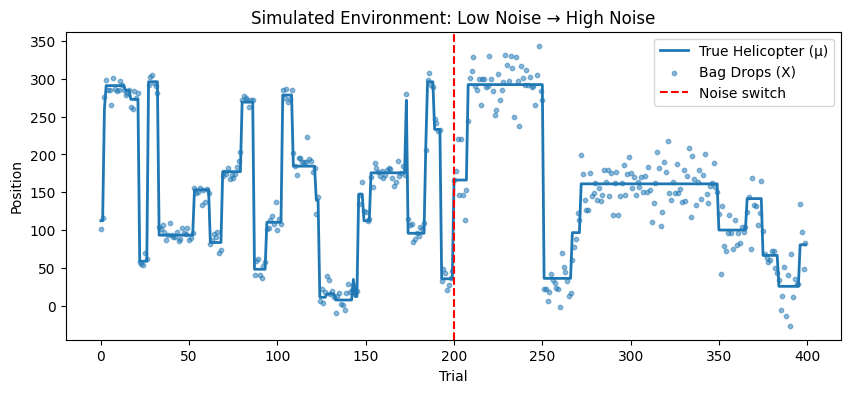

In [108]:
mu, X, sigma_seq = generate_environment()

import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(mu, label='True Helicopter (μ)', linewidth=2)
plt.scatter(range(len(X)), X, s=10, alpha=0.5, label='Bag Drops (X)')
plt.axvline(200, color='red', linestyle='--', label='Noise switch')
plt.title('Simulated Environment: Low Noise → High Noise')
plt.xlabel('Trial')
plt.ylabel('Position')
plt.legend()
plt.show()

# Normative Model

### Now, let's build our normative base model!
Combine the model specification together and build our model!

In [109]:
class NormativeBaseModel:
    """
    Base class for Nassar et al. (2016) models
    """
    def __init__(self, X, sigma_sequence, H=0.1,
                 uncertainty_scale=1.0, surprise_sensitivity=1.0, mu=None):
        # Store inputs
        self.X = X
        self.sigma_sequence = sigma_sequence
        self.mu = mu
        self.n_trials = len(X)

        # Model parameters
        self.hazard_rate = H
        self.uncertainty_scale = uncertainty_scale
        self.surprise_sensitivity = surprise_sensitivity

        # Initial belief
        self.initial_belief = X[0]
        self.belief = X[0]

        # Get noise from first trial (will update per trial)
        self.sigma_n = sigma_sequence[0]
        self.sigma_n_squared = sigma_sequence[0] ** 2

        # State variables
        self.sigma_mu_squared = self.sigma_n_squared
        self.tau = 0.1  # Match your initial tau
        self.alpha = 0.3

        # History tracking
        self.history = {
            'beliefs': [],
            'prediction_errors': [],
            'learning_rates': [],
            'uncertainties': [],
            'change_point_probs': []
        }

    def update(self, t):
        """
        Update belief for trial t
        """

        # Get current trial's noise level
        self.sigma_n = self.sigma_sequence[t]
        self.sigma_n_squared = self.sigma_sequence[t] ** 2

        # 1. Prediction error
        delta = prediction_error(self.X[t], self.belief)

        # 2. Change-point probability (with surprise sensitivity)
        omega = self._compute_change_point_prob(delta)

        # 3. Predictive variance
        sig_mu_sq = predictive_variance(omega, self.sigma_n, self.tau, delta)


        # 4. Update uncertainty
        # Scale down uncertainty
        sig_mu_sq /= self.uncertainty_scale
        # Update relative uncertainty
        self.tau = relative_uncertainty(np.sqrt(sig_mu_sq), self.sigma_n)

        # 5. Learning rate
        self.alpha = learning_rate(omega, self.tau)

        # 6. Update belief
        self.belief = update_belief(self.belief, self.alpha, delta)
        self.belief = np.clip(self.belief, 0, 300)

        # 7. Store history
        self._store_history(delta, omega)

        return self.belief

    def _compute_change_point_prob(self, delta):
        """Compute change-point probability with surprise sensitivity"""
        # Compute likelihood with surprise power
        var_no_cp = self.sigma_n_squared / (1 - self.tau)
        likelihood = stats.norm.pdf(delta, 0, np.sqrt(var_no_cp))
        likelihood_powered = likelihood ** self.surprise_sensitivity

        # Bayes rule
        num = self.hazard_rate / 300.0
        den = num + likelihood_powered * (1 - self.hazard_rate)
        omega = num / den

        return np.clip(omega, 1e-6, 1 - 1e-6)

    def _store_history(self, delta, omega):
        """Store trial results"""
        self.history['beliefs'].append(self.belief)
        self.history['prediction_errors'].append(delta)
        self.history['learning_rates'].append(self.alpha)
        self.history['uncertainties'].append(self.tau)
        self.history['change_point_probs'].append(omega)

    def run(self):
        """
        Run model on full task sequence
        Returns DataFrame compatible with function-based approach
        """
        # Initialize with first trial
        self.belief = self.X[0]
        self.tau = 0.1

        # Store first trial (no update, just initialization)
        self.history['beliefs'].append(self.belief)
        self.history['prediction_errors'].append(0.0)
        self.history['learning_rates'].append(0.0)
        self.history['uncertainties'].append(self.tau)
        self.history['change_point_probs'].append(0.0)

        # Run trials 1 through n_trials-1
        for t in range(1, self.n_trials):
            self.update(t)

        # Create DataFrame (compatible with your existing code)
        df = pd.DataFrame({
            "Trial": np.arange(1, self.n_trials + 1),
            "TruePosition": mu,
            "BagDrop": self.X,
            "Belief": self.history['beliefs'],
            "CPP": self.history['change_point_probs'],
            "RelUncertainty": self.history['uncertainties'],
            "LearningRate": self.history['learning_rates'],
            "PredictionError": self.history['prediction_errors']
        })

        return df

In [110]:
# Normative parameters
DEFAULT_H = 0.1
DEFAULT_UNCERTAINTY_SCALE = 1.0
DEFAULT_SURPRISE_SENSITIVITY = 1.0

# Create the normative model by passing default parameters
normative_model = NormativeBaseModel(X, sigma_seq, H=DEFAULT_H, uncertainty_scale=DEFAULT_UNCERTAINTY_SCALE, surprise_sensitivity=DEFAULT_SURPRISE_SENSITIVITY)
normative_model_results = normative_model.run()
display(normative_model_results)

,Trial,TruePosition,BagDrop,Belief,CPP,RelUncertainty,LearningRate,PredictionError
0,1,112.362036,101.243234,101.243234,0.000000,0.100000,0.000000,0.000000
1,2,112.362036,115.551058,103.133889,0.023996,0.110804,0.132141,14.307823
2,3,259.852844,275.644972,275.644886,0.999999,0.500000,1.000000,172.511083
3,4,290.972956,298.647303,284.306399,0.046970,0.345821,0.376548,23.002417
4,5,290.972956,285.164174,284.537556,0.011375,0.261079,0.269485,0.857775
...,...,...,...,...,...,...,...,...
395,396,25.652559,29.410103,29.395196,0.025016,0.168177,0.188986,0.018380
396,397,80.603208,134.484196,133.177747,0.975349,0.495677,0.987568,105.089000
397,398,80.603208,97.409640,119.713085,0.051919,0.342296,0.376443,-35.768107
398,399,80.603208,48.392023,81.532389,0.293746,0.342072,0.535335,-71.321062


# Plot the Normative Model (Optimal Behaviour in Response to our Determinisitc Environment)

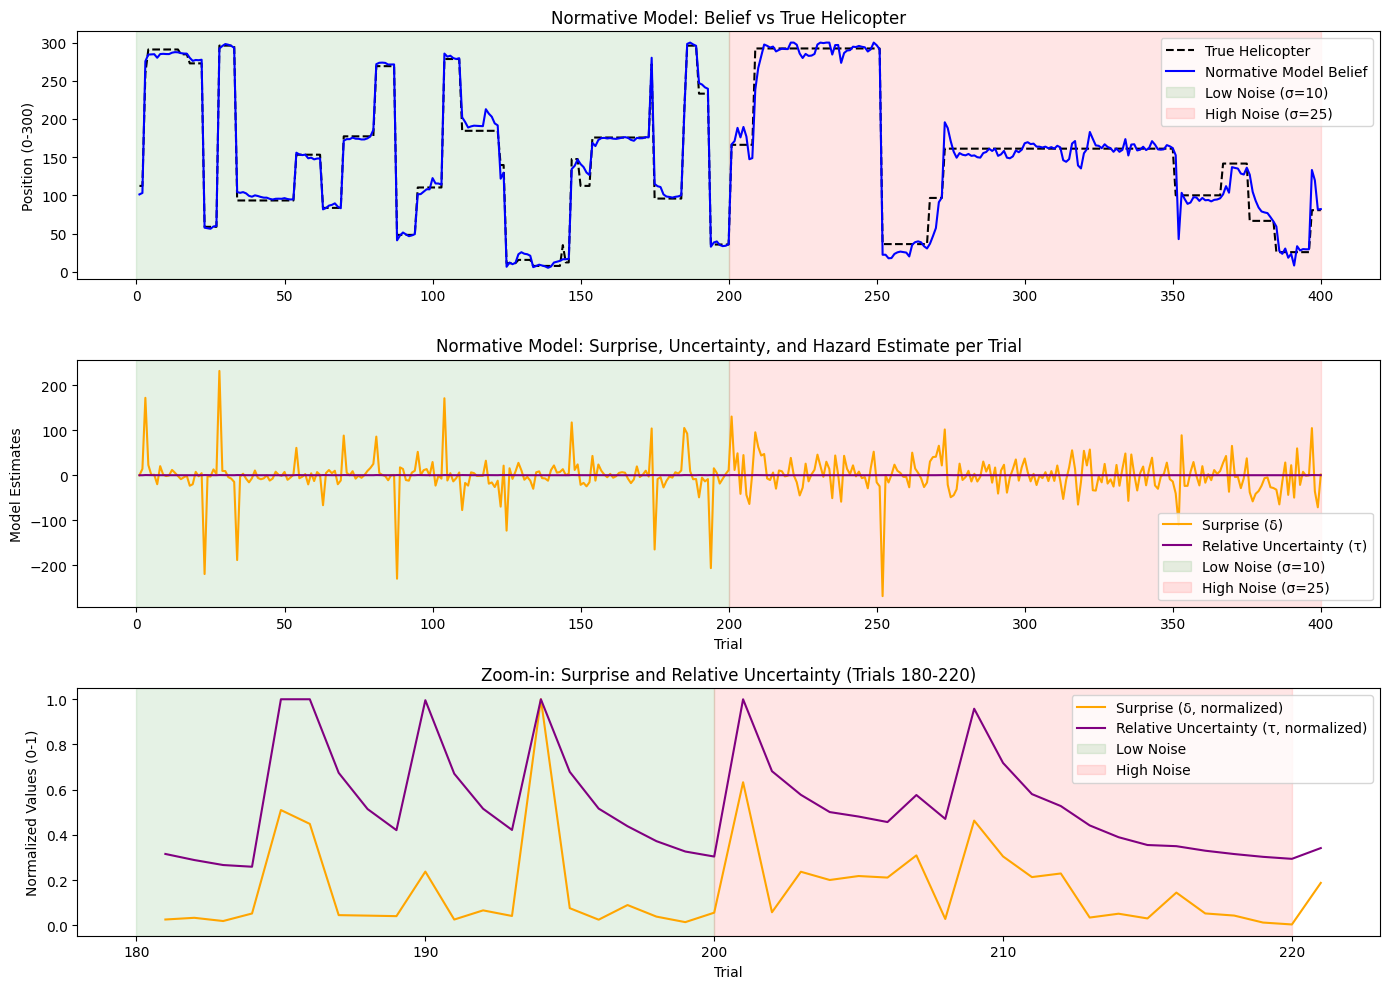

In [111]:
plt.figure(figsize=(14,10))

# Plot 1: Trial vs Screen Position
plt.subplot(3,1,1)
plt.plot(normative_model_results['Trial'], normative_model_results['TruePosition'], 'k--', label='True Helicopter')
plt.plot(normative_model_results['Trial'], normative_model_results['Belief'], 'b-', label='Normative Model Belief')
plt.axvspan(0, 200, color='green', alpha=0.1, label='Low Noise (σ=10)')
plt.axvspan(200, 400, color='red', alpha=0.1, label='High Noise (σ=25)')
plt.ylabel("Position (0-300)")
plt.title("Normative Model: Belief vs True Helicopter")
plt.legend()

# Trial vs Model Estimates (Surprise, Uncertainty)
plt.subplot(3,1,2)
plt.plot(normative_model_results['Trial'], normative_model_results['PredictionError'], color='orange', label='Surprise (δ)')
plt.plot(normative_model_results['Trial'], normative_model_results['RelUncertainty'], color='purple', label='Relative Uncertainty (τ)')
plt.axvspan(0, 200, color='green', alpha=0.1, label='Low Noise (σ=10)')
plt.axvspan(200, 400, color='red', alpha=0.1, label='High Noise (σ=25)')
plt.ylabel("Model Estimates")
plt.xlabel("Trial")
plt.title("Normative Model: Surprise, Uncertainty, and Hazard Estimate per Trial")
plt.legend()

# Zoom-in
zoom_start, zoom_end = 180, 220
trials_zoom = normative_model_results['Trial'][zoom_start:zoom_end+1]

# Normalize for visual clarity
pred_error_zoom = np.abs(normative_model_results['PredictionError'][zoom_start:zoom_end+1])
pred_error_norm = pred_error_zoom / np.max(pred_error_zoom)
rel_unc_zoom = normative_model_results['RelUncertainty'][zoom_start:zoom_end+1]
rel_unc_norm = rel_unc_zoom / np.max(rel_unc_zoom)

plt.subplot(3,1,3)
plt.plot(trials_zoom, pred_error_norm, color='orange', label='Surprise (δ, normalized)')
plt.plot(trials_zoom, rel_unc_norm, color='purple', label='Relative Uncertainty (τ, normalized)')
plt.axvspan(180, 200, color='green', alpha=0.1, label='Low Noise')
plt.axvspan(200, 220, color='red', alpha=0.1, label='High Noise')
plt.ylabel("Normalized Values (0-1)")
plt.xlabel("Trial")
plt.title("Zoom-in: Surprise and Relative Uncertainty (Trials 180-220)")
plt.legend()

plt.tight_layout()
plt.show()

# Flexible Models

3 flexible models listed in the paper take artificially manipulated parameters to reproduce the sub-optimal learnings.

# Flexible No. 1: Uncertainty Underestimators

This model artificially reduces estimated uncertainty on every trial by dividing the predictive variance (σ_μ²) by a constant (fixed_uncertainty_scale) each trial.

For the simulation figures, Nassar et al. used 10.

You may choose to use a different constant.

In [112]:
uncertainty_underestimate = NormativeBaseModel(X, sigma_seq, uncertainty_scale=10, mu=mu)
uncertainty_underestimate_results = uncertainty_underestimate.run()
display(uncertainty_underestimate_results)

,Trial,TruePosition,BagDrop,Belief,CPP,RelUncertainty,LearningRate,PredictionError
0,1,112.362036,101.243234,101.243234,0.000000,0.100000,0.000000,0.000000
1,2,112.362036,115.551058,101.758434,0.023996,0.012308,0.036008,14.307823
2,3,259.852844,275.644972,275.644814,0.999999,0.090909,0.999999,173.886538
3,4,290.972956,298.647303,278.287369,0.097373,0.019397,0.114881,23.002489
4,5,290.972956,285.164174,278.389146,0.011684,0.003153,0.014800,6.876805
...,...,...,...,...,...,...,...,...
395,396,25.652559,29.410103,25.882299,0.022945,0.002553,0.025440,3.619893
396,397,80.603208,134.484196,134.137867,0.996493,0.090670,0.996811,108.601897
397,398,80.603208,97.409640,131.411868,0.060977,0.014104,0.074221,-36.728227
398,399,80.603208,48.392023,60.437235,0.842902,0.076449,0.854912,-83.019845


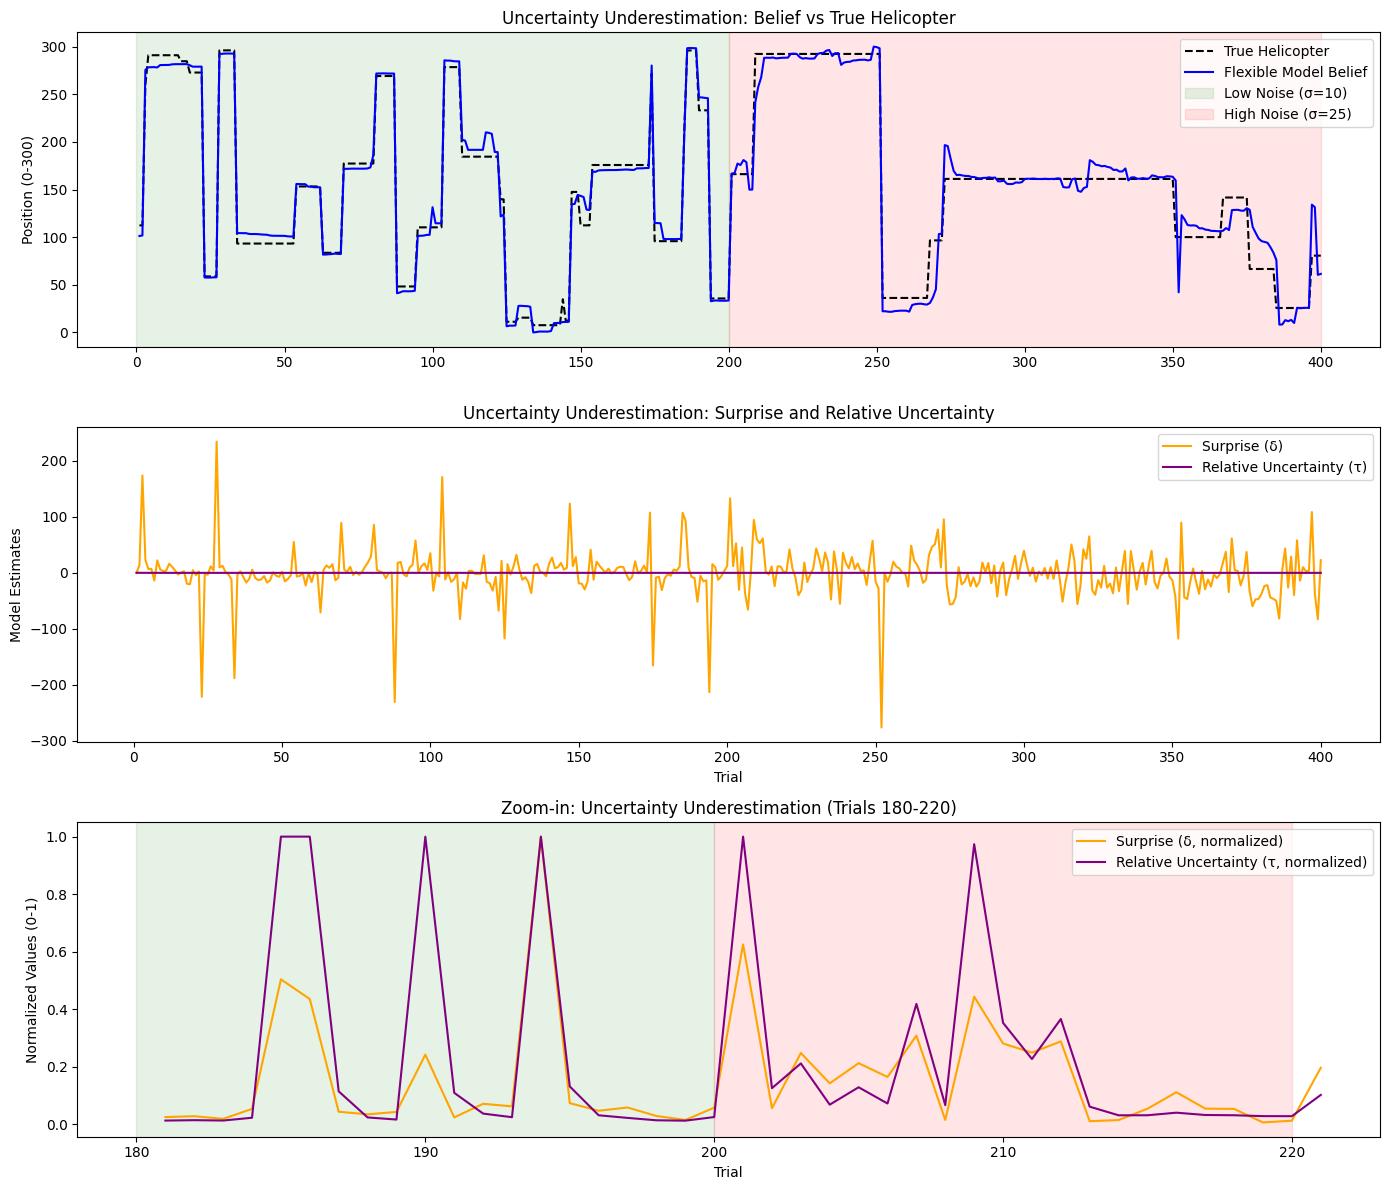

In [113]:
plt.figure(figsize=(14,12))

# Top plot: Belief vs True Helicopter
plt.subplot(3,1,1)
plt.plot(uncertainty_underestimate_results['Trial'], uncertainty_underestimate_results['TruePosition'], 'k--', label='True Helicopter')
plt.plot(uncertainty_underestimate_results['Trial'], uncertainty_underestimate_results['Belief'], 'b-', label='Flexible Model Belief')
plt.axvspan(0, 200, color='green', alpha=0.1, label='Low Noise (σ=10)')
plt.axvspan(200, 400, color='red', alpha=0.1, label='High Noise (σ=25)')
plt.ylabel("Position (0-300)")
plt.title("Uncertainty Underestimation: Belief vs True Helicopter")
plt.legend()

# Middle plot: Prediction error & relative uncertainty
plt.subplot(3,1,2)
plt.plot(uncertainty_underestimate_results['Trial'], uncertainty_underestimate_results['PredictionError'], color='orange', label='Surprise (δ)')
plt.plot(uncertainty_underestimate_results['Trial'], uncertainty_underestimate_results['RelUncertainty'], color='purple', label='Relative Uncertainty (τ)')
plt.ylabel("Model Estimates")
plt.xlabel("Trial")
plt.title("Uncertainty Underestimation: Surprise and Relative Uncertainty")
plt.legend()

# Bottom plot: Zoom-in (trials 180-220)
zoom_start, zoom_end = 180, 220
plt.subplot(3,1,3)
# Normalize for visibility
pred_zoom = np.abs(uncertainty_underestimate_results['PredictionError'][zoom_start:zoom_end+1])
pred_zoom_norm = pred_zoom / np.max(pred_zoom)
tau_zoom = uncertainty_underestimate_results['RelUncertainty'][zoom_start:zoom_end+1]
tau_zoom_norm = tau_zoom / np.max(tau_zoom)
trials_zoom = uncertainty_underestimate_results['Trial'][zoom_start:zoom_end+1]

plt.plot(trials_zoom, pred_zoom_norm, color='orange', label='Surprise (δ, normalized)')
plt.plot(trials_zoom, tau_zoom_norm, color='purple', label='Relative Uncertainty (τ, normalized)')
plt.axvspan(180, 200, color='green', alpha=0.1)
plt.axvspan(200, 220, color='red', alpha=0.1)
plt.ylabel("Normalized Values (0-1)")
plt.xlabel("Trial")
plt.title("Zoom-in: Uncertainty Underestimation (Trials 180-220)")
plt.legend()

plt.tight_layout()
plt.show()

# Flexible No. 2: Surprise Insensitivity

In [129]:
surprise_insensitive_model = NormativeBaseModel(X, sigma_seq, surprise_sensitivity=0.2, mu=mu)
surprise_insensitive_model_results = surprise_insensitive_model.run()
display(surprise_insensitive_model_results)

,Trial,TruePosition,BagDrop,Belief,CPP,RelUncertainty,LearningRate,PredictionError
0,1,112.362036,101.243234,101.243234,0.000000,0.100000,0.000000,0.000000
1,2,112.362036,115.551058,102.565484,0.000856,0.091637,0.092414,14.307823
2,3,259.852844,275.644972,275.644885,0.999999,0.500000,1.000000,173.079487
3,4,290.972956,298.647303,283.333628,0.000984,0.333602,0.334258,23.002418
4,5,290.972956,285.164174,283.793064,0.000736,0.250432,0.250983,1.830547
...,...,...,...,...,...,...,...,...
395,396,25.652559,29.410103,75.113688,0.001205,0.040553,0.041709,-47.692805
396,397,80.603208,134.484196,77.594611,0.001460,0.040387,0.041787,59.370508
397,398,80.603208,97.409640,78.397337,0.000903,0.039644,0.040511,19.815029
398,399,80.603208,48.392023,77.200273,0.000976,0.038957,0.039895,-30.005314


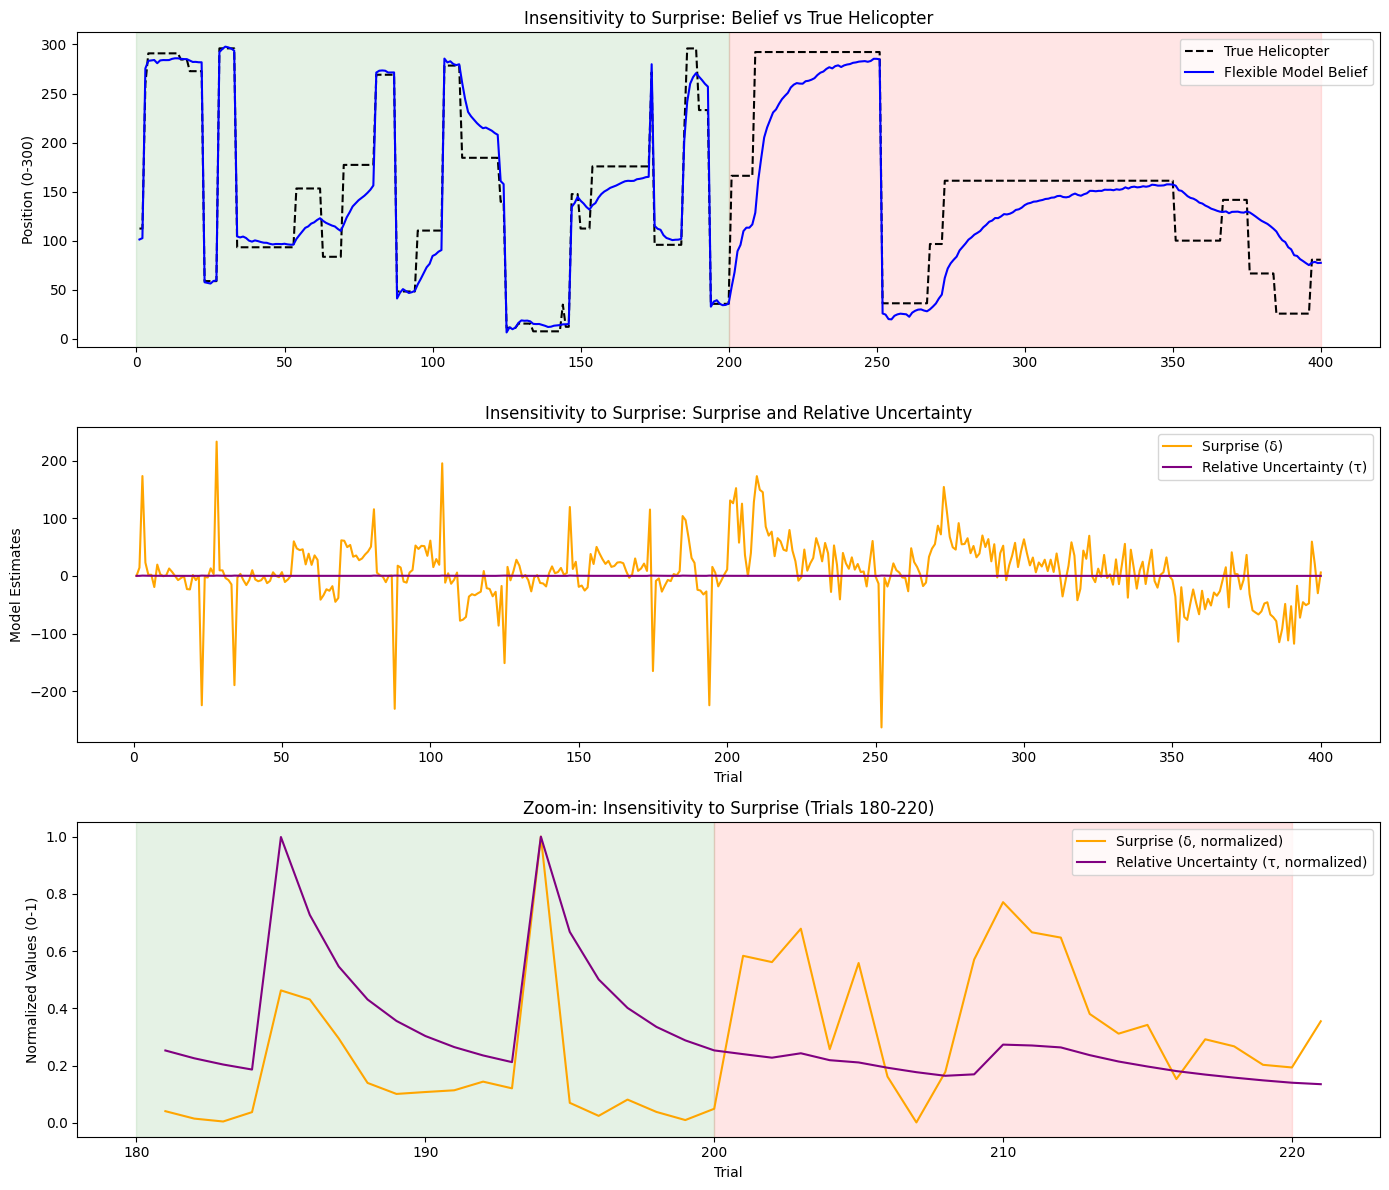

In [115]:
plt.figure(figsize=(14,12))

# Top plot: Belief vs True Helicopter
plt.subplot(3,1,1)
plt.plot(surprise_insensitive_model_results['Trial'], surprise_insensitive_model_results['TruePosition'], 'k--', label='True Helicopter')
plt.plot(surprise_insensitive_model_results['Trial'], surprise_insensitive_model_results['Belief'], 'b-', label='Flexible Model Belief')
plt.axvspan(0, 200, color='green', alpha=0.1)
plt.axvspan(200, 400, color='red', alpha=0.1)
plt.ylabel("Position (0-300)")
plt.title("Insensitivity to Surprise: Belief vs True Helicopter")
plt.legend()

# Middle plot: Prediction error & relative uncertainty
plt.subplot(3,1,2)
plt.plot(surprise_insensitive_model_results['Trial'], surprise_insensitive_model_results['PredictionError'], color='orange', label='Surprise (δ)')
plt.plot(surprise_insensitive_model_results['Trial'], surprise_insensitive_model_results['RelUncertainty'], color='purple', label='Relative Uncertainty (τ)')
plt.ylabel("Model Estimates")
plt.xlabel("Trial")
plt.title("Insensitivity to Surprise: Surprise and Relative Uncertainty")
plt.legend()

# Bottom plot: Zoom-in
zoom_start, zoom_end = 180, 220
plt.subplot(3,1,3)
pred_zoom = np.abs(surprise_insensitive_model_results['PredictionError'][zoom_start:zoom_end+1])
pred_zoom_norm = pred_zoom / np.max(pred_zoom)
tau_zoom = surprise_insensitive_model_results['RelUncertainty'][zoom_start:zoom_end+1]
tau_zoom_norm = tau_zoom / np.max(tau_zoom)
trials_zoom = surprise_insensitive_model_results['Trial'][zoom_start:zoom_end+1]

plt.plot(trials_zoom, pred_zoom_norm, color='orange', label='Surprise (δ, normalized)')
plt.plot(trials_zoom, tau_zoom_norm, color='purple', label='Relative Uncertainty (τ, normalized)')
plt.axvspan(180, 200, color='green', alpha=0.1)
plt.axvspan(200, 220, color='red', alpha=0.1)
plt.ylabel("Normalized Values (0-1)")
plt.xlabel("Trial")
plt.title("Zoom-in: Insensitivity to Surprise (Trials 180-220)")
plt.legend()

plt.tight_layout()
plt.show()

# Flexible No. 3: Low Hazard Rate Environment

In [116]:
low_hazard_rate_model = NormativeBaseModel(X, sigma_seq, H=0.001, mu=mu)
low_hazard_rate_model_results = low_hazard_rate_model.run()
display(low_hazard_rate_model_results)

,Trial,TruePosition,BagDrop,Belief,CPP,RelUncertainty,LearningRate,PredictionError
0,1,112.362036,101.243234,101.243234,0.000000,0.100000,0.000000,0.000000
1,2,112.362036,115.551058,102.549519,0.000221,0.091097,0.091299,14.307823
2,3,259.852844,275.644972,275.644885,0.999999,0.500000,1.000000,173.095453
3,4,290.972956,298.647303,283.321954,0.000444,0.333455,0.333751,23.002418
4,5,290.972956,285.164174,283.782851,0.000104,0.250108,0.250185,1.842220
...,...,...,...,...,...,...,...,...
395,396,25.652559,29.410103,35.046007,0.000223,0.067631,0.067839,-6.046063
396,397,80.603208,134.484196,79.149482,0.256864,0.251183,0.443527,99.438190
397,398,80.603208,97.409640,82.822275,0.000295,0.200901,0.201137,18.260158
398,399,80.603208,48.392023,77.039080,0.000499,0.167553,0.167968,-34.430252


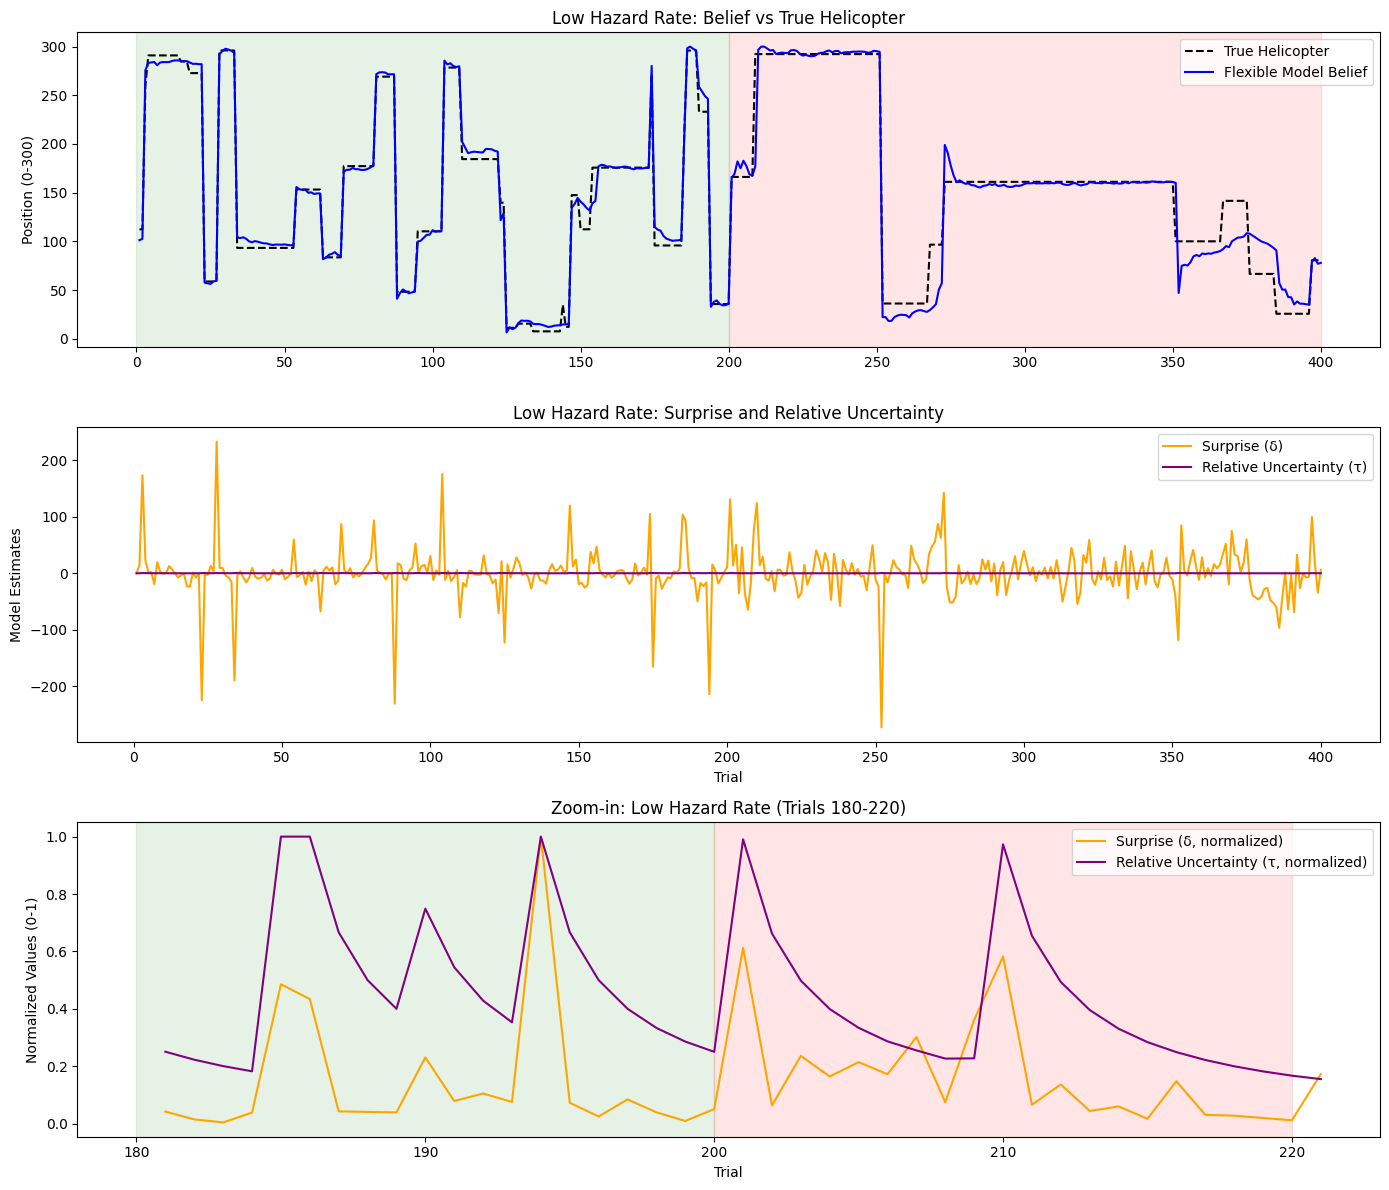

In [117]:
plt.figure(figsize=(14,12))

# Top plot: Belief vs True Helicopter
plt.subplot(3,1,1)
plt.plot(low_hazard_rate_model_results['Trial'], low_hazard_rate_model_results['TruePosition'], 'k--', label='True Helicopter')
plt.plot(low_hazard_rate_model_results['Trial'], low_hazard_rate_model_results['Belief'], 'b-', label='Flexible Model Belief')
plt.axvspan(0, 200, color='green', alpha=0.1)
plt.axvspan(200, 400, color='red', alpha=0.1)
plt.ylabel("Position (0-300)")
plt.title("Low Hazard Rate: Belief vs True Helicopter")
plt.legend()

# Middle plot: Prediction error & relative uncertainty
plt.subplot(3,1,2)
plt.plot(low_hazard_rate_model_results['Trial'], low_hazard_rate_model_results['PredictionError'], color='orange', label='Surprise (δ)')
plt.plot(low_hazard_rate_model_results['Trial'], low_hazard_rate_model_results['RelUncertainty'], color='purple', label='Relative Uncertainty (τ)')
plt.ylabel("Model Estimates")
plt.xlabel("Trial")
plt.title("Low Hazard Rate: Surprise and Relative Uncertainty")
plt.legend()

# Bottom plot: Zoom-in
zoom_start, zoom_end = 180, 220
plt.subplot(3,1,3)
pred_zoom = np.abs(low_hazard_rate_model_results['PredictionError'][zoom_start:zoom_end+1])
pred_zoom_norm = pred_zoom / np.max(pred_zoom)
tau_zoom = low_hazard_rate_model_results['RelUncertainty'][zoom_start:zoom_end+1]
tau_zoom_norm = tau_zoom / np.max(tau_zoom)
trials_zoom = low_hazard_rate_model_results['Trial'][zoom_start:zoom_end+1]

plt.plot(trials_zoom, pred_zoom_norm, color='orange', label='Surprise (δ, normalized)')
plt.plot(trials_zoom, tau_zoom_norm, color='purple', label='Relative Uncertainty (τ, normalized)')
plt.axvspan(180, 200, color='green', alpha=0.1)
plt.axvspan(200, 220, color='red', alpha=0.1)
plt.ylabel("Normalized Values (0-1)")
plt.xlabel("Trial")
plt.title("Zoom-in: Low Hazard Rate (Trials 180-220)")
plt.legend()

plt.tight_layout()
plt.show()

# Learning Rate Trajectories Compared to the Normative Model

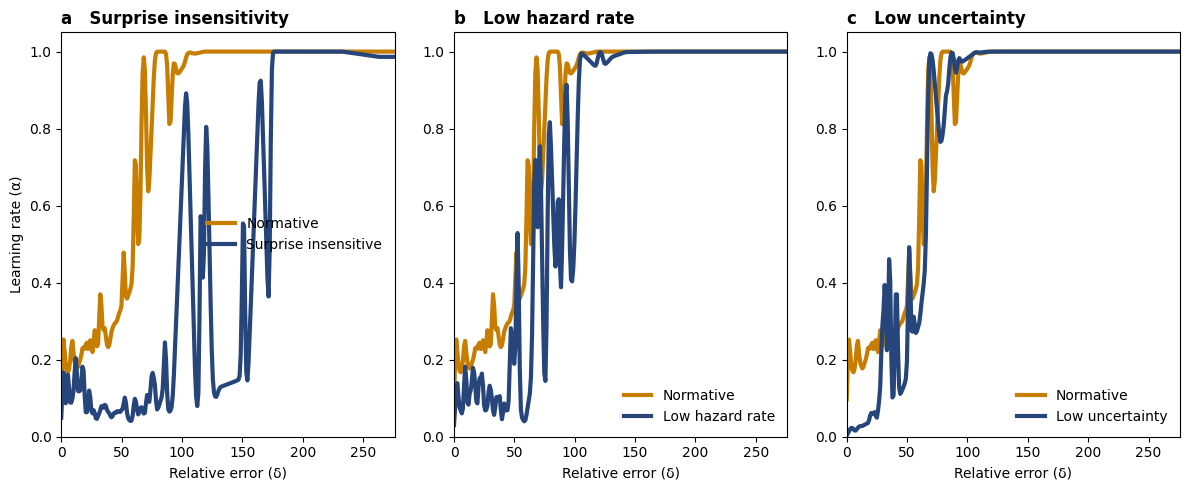

In [118]:
all_models = [
    normative_model_results,
    surprise_insensitive_model_results,
    low_hazard_rate_model_results,
    uncertainty_underestimate_results,
]

max_pe = max(np.abs(m['PredictionError']).max() for m in all_models)
delta_vals = np.linspace(0, max_pe, 300)  # covers full realistic range

# ---- 2. Helper: sort & interpolate smoothly ----
def sorted_interp(model, delta_vals, smooth_sigma=1):
    """Sorts model data by |PredictionError| before interpolation and smooths."""
    idx = np.argsort(np.abs(model['PredictionError']))
    x = np.abs(model['PredictionError'].values[idx])
    y = model['LearningRate'].values[idx]
    # Interpolate to uniform x scale
    interp_y = np.interp(delta_vals, x, y)
    # Optional smoothing for visual polish
    return gaussian_filter1d(interp_y, sigma=smooth_sigma)

# ---- 3. Compute curves ----
alpha_norm = sorted_interp(normative_model_results, delta_vals)
alpha_surprise = sorted_interp(surprise_insensitive_model_results, delta_vals)
alpha_hazard = sorted_interp(low_hazard_rate_model_results, delta_vals)
alpha_uncertainty = sorted_interp(uncertainty_underestimate_results, delta_vals)

# ---- 4. Styling ----
plt.figure(figsize=(12, 5))

colors = {
    'normative': '#c67d00',  # warm gold
    'variant': '#26457b'     # dark blue
}

# ---- (a) Surprise insensitivity ----
plt.subplot(1, 3, 1)
plt.plot(delta_vals, alpha_norm, color=colors['normative'], linewidth=3, label='Normative')
plt.plot(delta_vals, alpha_surprise, color=colors['variant'], linewidth=3, label='Surprise insensitive')
plt.title("a   Surprise insensitivity", loc='left', fontsize=12, fontweight='bold')
plt.xlabel("Relative error (δ)")
plt.ylabel("Learning rate (α)")
plt.xlim(0, max_pe)
plt.ylim(0, 1.05)
plt.legend(frameon=False)
plt.tick_params(direction='out')
plt.grid(False)

# ---- (b) Low hazard rate ----
plt.subplot(1, 3, 2)
plt.plot(delta_vals, alpha_norm, color=colors['normative'], linewidth=3, label='Normative')
plt.plot(delta_vals, alpha_hazard, color=colors['variant'], linewidth=3, label='Low hazard rate')
plt.title("b   Low hazard rate", loc='left', fontsize=12, fontweight='bold')
plt.xlabel("Relative error (δ)")
plt.xlim(0, max_pe)
plt.ylim(0, 1.05)
plt.legend(frameon=False)
plt.tick_params(direction='out')
plt.grid(False)

# ---- (c) Low uncertainty ----
plt.subplot(1, 3, 3)
plt.plot(delta_vals, alpha_norm, color=colors['normative'], linewidth=3, label='Normative')
plt.plot(delta_vals, alpha_uncertainty, color=colors['variant'], linewidth=3, label='Low uncertainty')
plt.title("c   Low uncertainty", loc='left', fontsize=12, fontweight='bold')
plt.xlabel("Relative error (δ)")
plt.xlim(0, max_pe)
plt.ylim(0, 1.05)
plt.legend(frameon=False)
plt.tick_params(direction='out')
plt.grid(False)

plt.tight_layout(w_pad=2)
plt.show()

## Your Turn: Background

Nassar et. al. 2022 recreates this model to study the all-or-nothing belief system update observed in individuals with schizophrenia.

The finding was that of pronounced reduction in moderate belief updates. They instead relied on extremes:

1. Non-updates/Perseverative responses: Completely ignoring new information (learning rate near 0).

2. Total updates: Completely adopting the new information (learning rate near 1).

# A New Environment

One slight modification the 2022 study made to the 2016 experiment, was an "odd-ball condition", which was a slight drift of the helicopter via **random walk**. This were essentially one-off outliers that didn't actually indicate a change-point occurence. Really unexpected bag locations were meant to be indicative of an odd-ball, encouraged to be ignored by participants.

In [119]:
def generate_oddball_environment(n_trials=400, H_oddball=0.1, sigma=20, drift_rate=10, seed=555):
    """
    Generate helicopter (true) and bag (observed) positions for oddball condition:
    - Helicopter undergoes Gaussian random walk (gradual drift)
    - Occasional oddball bag drops (unrelated to helicopter position)
    - Static noise level throughout all trials
    Hazard rate H_oddball controls probability of oddball events (not changepoints)
    Range of positions: 0-300
    """
    np.random.seed(seed)  # reproducibility

    # Single static noise level for all trials
    sigma_sequence = np.full(n_trials, sigma)

    mu = np.zeros(n_trials)  # true helicopter position
    X = np.zeros(n_trials)   # observed bag drops
    is_oddball = np.zeros(n_trials, dtype=bool)  # track oddball trials

    # Initialize helicopter in center of range
    mu[0] = 150  # Start at center

    X[0] = np.random.normal(mu[0], sigma_sequence[0])

    # Generate trials
    for t in range(1, n_trials):
        # Helicopter undergoes random walk with reflecting boundaries
        drift = np.random.normal(0, drift_rate)
        proposed_position = mu[t - 1] + drift

        # Reflecting boundaries: bounce back if hitting edges
        if proposed_position < 0:
            mu[t] = -proposed_position  # Reflect off bottom
        elif proposed_position > 300:
            mu[t] = 600 - proposed_position  # Reflect off top
        else:
            mu[t] = proposed_position

        # Ensure still within bounds after reflection
        mu[t] = np.clip(mu[t], 0, 300)

        # Oddball decision: bag from random location or helicopter location?
        if np.random.rand() < H_oddball:
            # Oddball: bag from uniform distribution (anywhere on screen)
            X[t] = np.random.uniform(0, 300)
            is_oddball[t] = True
        else:
            # Normal: bag from helicopter location with noise
            X[t] = np.random.normal(mu[t], sigma_sequence[t])

    return mu, X, sigma_sequence, is_oddball

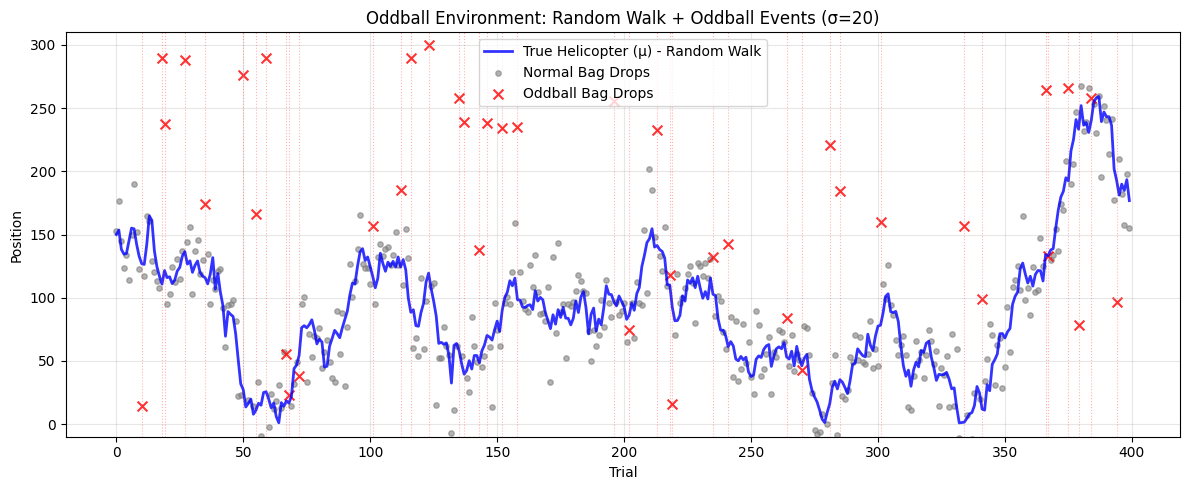

Total trials: 400
Oddball events: 41 (10.2%)
Oddball trials: [10 18 19 27 35 50 55 59 67 68]... (showing first 10)


In [120]:
mu_oddball, X_oddball, sigma_seq_oddball, is_oddball = generate_oddball_environment()

plt.figure(figsize=(12, 5))

# Plot true helicopter position (random walk)
plt.plot(mu_oddball, label='True Helicopter (μ) - Random Walk', linewidth=2, color='blue', alpha=0.8)

# Plot normal bag drops
normal_trials = ~is_oddball
plt.scatter(np.where(normal_trials)[0], X_oddball[normal_trials],
            s=15, alpha=0.6, label='Normal Bag Drops', color='gray')

# Plot oddball bag drops in distinct color
oddball_trials = is_oddball
plt.scatter(np.where(oddball_trials)[0], X_oddball[oddball_trials],
            s=50, alpha=0.8, label='Oddball Bag Drops', color='red', marker='x')

# Add vertical dotted lines for each oddball occurrence
for t in np.where(is_oddball)[0]:
    plt.axvline(t, color='red', linestyle=':', alpha=0.3, linewidth=0.8)

plt.title('Oddball Environment: Random Walk + Oddball Events (σ=20)')
plt.xlabel('Trial')
plt.ylabel('Position')
plt.ylim(-10, 310)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Total trials: {len(X_oddball)}")
print(f"Oddball events: {np.sum(is_oddball)} ({100*np.mean(is_oddball):.1f}%)")
print(f"Oddball trials: {np.where(is_oddball)[0][:10]}... (showing first 10)")

## How would we expect our normative model to learn in this environment?

In [121]:
# REMINDER OF VARIABLES:

# mu_oddball, X_oddball, sigma_seq_oddball, is_oddball = generate_oddball_environment()

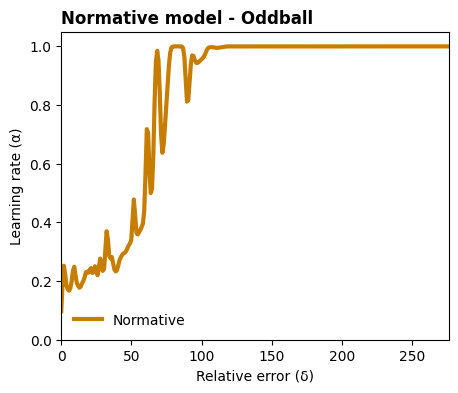

In [122]:
norm_oddball = NormativeBaseModel(X_oddball, sigma_seq_oddball, mu=mu_oddball)
norm_oddball_results = norm_oddball.run()

plt.figure(figsize=(5, 4))
plt.plot(delta_vals, alpha_norm, color=colors['normative'], linewidth=3, label='Normative')
plt.title("Normative model - Oddball", loc='left', fontsize=12, fontweight='bold')
plt.xlabel("Relative error (δ)")
plt.ylabel("Learning rate (α)")
plt.xlim(0, max(delta_vals))
plt.ylim(0, 1.05)
plt.legend(frameon=False)
plt.tick_params(direction='out')
plt.grid(False)
plt.show()

## How MIGHT we expect older participants to learn in this environment, given our 2016 model?

We have to also keep in mind that this model only contains the parameters from the 2016 model, and may miss possible factors that are captured in the 2021 model.

In [123]:
older_oddball = NormativeBaseModel(X_oddball, sigma_seq_oddball, uncertainty_scale=10, H = 0.125)
older_oddball_results = older_oddball.run()

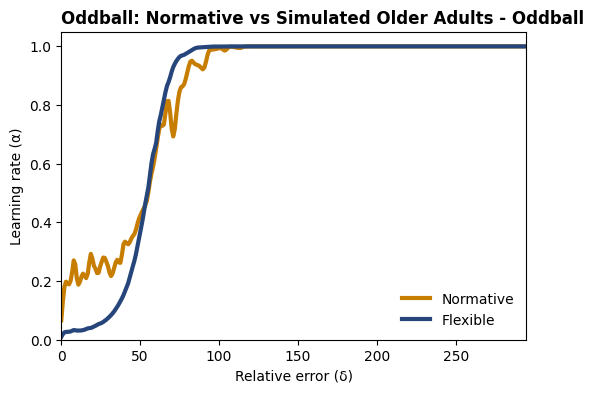

In [124]:
# ---- 1. Prepare delta_vals ----
max_pe = max(
    np.abs(norm_oddball_results['PredictionError']).max(),
    np.abs(older_oddball_results['PredictionError']).max()
)
delta_vals = np.linspace(0, max_pe, 300)  # smooth range

# ---- 2. Helper for sorting + interpolation + smoothing ----
def sorted_interp(model, delta_vals, smooth_sigma=1):
    idx = np.argsort(np.abs(model['PredictionError']))
    x = np.abs(model['PredictionError'].values[idx])
    y = model['LearningRate'].values[idx]
    interp_y = np.interp(delta_vals, x, y)
    return gaussian_filter1d(interp_y, sigma=smooth_sigma)

# ---- 3. Compute curves ----
alpha_norm = sorted_interp(norm_oddball_results, delta_vals)
alpha_flex = sorted_interp(older_oddball_results, delta_vals)

# ---- 4. Plot ----
colors = {
    'normative': '#c67d00',  # warm gold
    'variant': '#26457b'     # dark blue
}

plt.figure(figsize=(6, 4))
plt.plot(delta_vals, alpha_norm, color=colors['normative'], linewidth=3, label='Normative')
plt.plot(delta_vals, alpha_flex, color=colors['variant'], linewidth=3, label='Flexible')
plt.title("Oddball: Normative vs Simulated Older Adults - Oddball", loc='left', fontsize=12, fontweight='bold')
plt.xlabel("Relative error (δ)")
plt.ylabel("Learning rate (α)")
plt.xlim(0, max_pe)
plt.ylim(0, 1.05)
plt.legend(frameon=False)
plt.tick_params(direction='out')
plt.grid(False)
plt.show()